In [43]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc 
from locscale.include.emmer.pdb.fitting_tools import map_values_at_atomic_locations

import gemmi

In [44]:
emdb_pdb = "0282_6huo"
emdb, pdb = emdb_pdb.split("_")
folder = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/feature_enhance_test_maps_hybrid_60k/{}".format(emdb_pdb)
mean_prediction_intensity = os.path.join(folder, f"emd_{emdb}_emmernet_output_mean.mrc")
p_value_map_path = os.path.join(folder,"hallucinations_probabilities_map3.mrc")
z_score_map_path = os.path.join(folder, "z_scores_calibrated.mrc")

atomic_models_location = "/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models"
pdb_path = os.path.join(atomic_models_location, f"PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")

<AxesSubplot:ylabel='Count'>

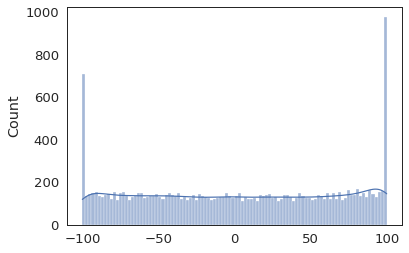

In [45]:
# plot distribution of p-values for atomic locations 
import seaborn as sns
map_values_pdb = map_values_at_atomic_locations(emmap_path=p_value_map_path, input_pdb=pdb_path)

sns.histplot(map_values_pdb, kde=True, bins=100)


In [46]:
from locscale.include.emmer.pdb.pdb_utils import get_coordinates, get_atomic_point_map
from locscale.include.emmer.ndimage.map_utils import convert_mrc_to_pdb_position, convert_pdb_to_mrc_position

pdb_coordinates = get_coordinates(pdb_path)

st = gemmi.read_structure(pdb_path)

backbone_atoms = ["N", "CA", "C", "O"]
backbone_coordinates = []
side_chain_coordinates = []

for chain in st[0]:
    for res in chain:
        for atom in res:
            if atom.name in backbone_atoms:
                backbone_coordinates.append(atom.pos)
            else:
                side_chain_coordinates.append(atom.pos)

backbone_coordinates = np.array(backbone_coordinates)
side_chain_coordinates = np.array(side_chain_coordinates)

p_value_map, apix = load_map(p_value_map_path)

mrc_backbone_coordinates = convert_pdb_to_mrc_position(backbone_coordinates, apix)
mrc_side_chain_coordinates = convert_pdb_to_mrc_position(side_chain_coordinates, apix)

atomic_point_map_backbone = get_atomic_point_map(mrc_backbone_coordinates, p_value_map.shape).astype(bool)
atomic_point_map_side_chain = get_atomic_point_map(mrc_side_chain_coordinates, p_value_map.shape).astype(bool)

backbone_p_values = p_value_map[atomic_point_map_backbone]
side_chain_p_values = p_value_map[atomic_point_map_side_chain]


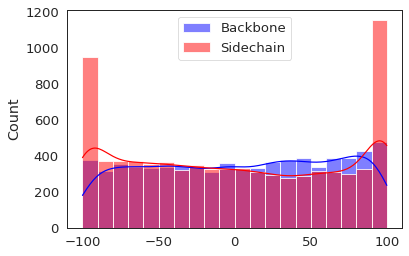

In [47]:
sns.histplot(backbone_p_values, color='blue', label='Backbone', alpha=0.5, kde=True, bins=20)
sns.histplot(side_chain_p_values, color='red', label='Sidechain', alpha=0.5, kde=True, bins=20)

plt.legend()

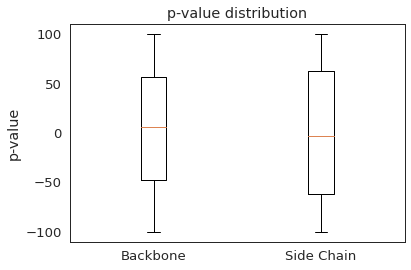

In [48]:
#plt.violinplot([backbone_p_values, side_chain_p_values], showmeans=False, showmedians=True, showextrema=False)
plt.boxplot([backbone_p_values, side_chain_p_values])
plt.xticks([1, 2], ['Backbone', 'Side Chain'])
plt.ylabel('p-value')
plt.title('p-value distribution')
plt.show()

In [49]:
print("Median backbone p-value:", np.median(backbone_p_values))
print("Median sidechain p-value:", np.median(side_chain_p_values))

# percentage bacbone p-values < 0.05
print("Percentage backbone p-values < 0.05:", np.sum(backbone_p_values < 0.05) / len(backbone_p_values))
# percentage sidechain p-values < 0.05
print("Percentage sidechain p-values < 0.05:", np.sum(side_chain_p_values < 0.05) / len(side_chain_p_values))

Median backbone p-value: 5.9190664
Median sidechain p-value: -2.8978438
Percentage backbone p-values < 0.05: 0.47269695706544396
Percentage sidechain p-values < 0.05: 0.5124764890282132


In [50]:
# are refined B-factors correlated with p-values?
convert_to_mrc_positition = lambda x: convert_pdb_to_mrc_position([x], apix=apix)[0]

bfactor_values = []
p_values = []
bfactor_values_side_chain = []
p_values_side_chain = []

for cra in st[0].all():
    bfactor_values.append(cra.atom.b_iso)
    mrc_postition = convert_to_mrc_positition(cra.atom.pos.tolist())
    p_values.append(p_value_map[mrc_postition[0], mrc_postition[1], mrc_postition[2]])
    atom_name = cra.atom.name
    if atom_name in ["N", "CA", "C", "O"]:
        bfactor_values_side_chain.append(cra.atom.b_iso)
        p_values_side_chain.append(p_value_map[mrc_postition[0], mrc_postition[1], mrc_postition[2]])

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_binned_correlation(xarray, yarray, xlabel="x", ylabel="y",\
                        num_bins=50, figsize_cm=(8, 8), font='Helvetica', fontscale=1.5, linewidth=2, marker='o', markersize=10):
    """
    Plot the binned squared residuals as a function of variance.

    Parameters:
    - variances_combined_sampled: numpy array of variances.
    - squared_residuals_sampled: numpy array of squared residuals.
    - num_bins: number of bins for the x-axis (default is 50).
    """
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import seaborn as sns    
    from matplotlib.pyplot import cm
    import matplotlib as mpl
    ## Function not generic
    mpl.rcParams['pdf.fonttype'] = 42
    figsize = (figsize_cm[0] / 2.54, figsize_cm[1] / 2.54)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, rotation=90, ha="center")
    import warnings
    warnings.filterwarnings('ignore')
    variances_combined_sampled = np.array(xarray)
    squared_residuals_sampled = np.array(yarray)
    # Binning the variances_combined_sampled data
    bins = np.linspace(variances_combined_sampled.min(), variances_combined_sampled.max(), num_bins + 1)
    bin_indices = np.digitize(variances_combined_sampled, bins)

    # Compute the statistics for each bin
    bin_weight_threshold = 1e-9
    bin_not_empty = lambda i: len(variances_combined_sampled[bin_indices == i]) > 0
    bin_weight_check = lambda i: True#len(variances_combined_sampled[bin_indices == i]) / len(variances_combined_sampled) > bin_weight_threshold
    weight_per_bin = [len(variances_combined_sampled[bin_indices == i]) / len(variances_combined_sampled) for i in range(1, len(bins)) if bin_not_empty(i)]
    uncertainty_bin_means = [variances_combined_sampled[bin_indices == i].mean() for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
    residual_means = [squared_residuals_sampled[bin_indices == i].mean() for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
    residual_stds = [squared_residuals_sampled[bin_indices == i].std() for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
    #residual_standard_errors = [squared_residuals_sampled[bin_indices == i].std() / np.sqrt(len(squared_residuals_sampled[bin_indices == i])) for i in range(1, len(bins))]
    confidence_interval = 95
    z_score = 1.96
    residual_standard_errors = [z_score * squared_residuals_sampled[bin_indices == i].std() / np.sqrt(len(squared_residuals_sampled[bin_indices == i])) for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
    
    uncertainty_bin_values = [variances_combined_sampled[bin_indices == i] for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
    residual_bin_values = [squared_residuals_sampled[bin_indices == i] for i in range(1, len(bins)) if bin_not_empty(i) and bin_weight_check(i)]
        
    ax.plot(uncertainty_bin_means, residual_means, color='blue', marker='o')
    # plot diagonal line for reference
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.fill_between(uncertainty_bin_means, np.array(residual_means) - np.array(residual_standard_errors), np.array(residual_means) + np.array(residual_standard_errors), color='skyblue', alpha=0.4, label='1 Standard Deviation')
    
    residues_max = np.max(residual_means)
    uncertainty_max = np.max(uncertainty_bin_means)
    ymax = np.max([residues_max, uncertainty_max])
    # ax.set_xlim(-0.01, 0.15)
    # ax.set_ylim(-0.01, 0.25)
    # xticks = [0, 0.1]
    # yticks = [0, 0.1, 0.2]
    # # ax.set_xticks(xticks)
    # ax.set_yticks(yticks)
    # ax.set_xticklabels(xticks)
    # ax.set_yticklabels(yticks)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax
    

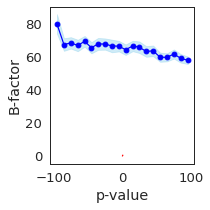

In [52]:
fig, ax = plot_binned_correlation(p_values_side_chain, bfactor_values_side_chain, num_bins=20, xlabel='p-value', ylabel='B-factor')


In [53]:
significant_p_values = []
bfactor_at_significant_p_values = []

for i in range(len(p_values)):
    p_atom = p_values[i]
    b_atom = bfactor_values[i]
    if p_atom < 0.05:
        significant_p_values.append(p_atom)
        bfactor_at_significant_p_values.append(b_atom)


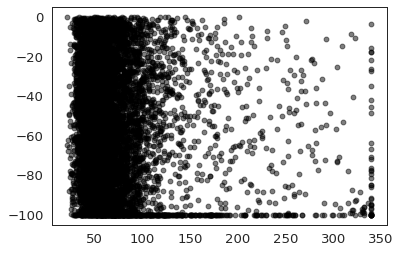

In [54]:
plt.plot(bfactor_at_significant_p_values, significant_p_values, 'o', color='black', alpha=0.5)

<AxesSubplot:ylabel='Count'>

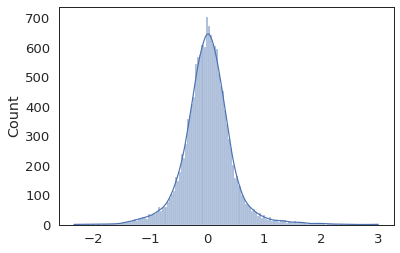

In [55]:
# do the same analysis for z-score distribution

z_score_all = map_values_at_atomic_locations(emmap_path=z_score_map_path, input_pdb=pdb_path)

sns.histplot(z_score_all, kde=True)

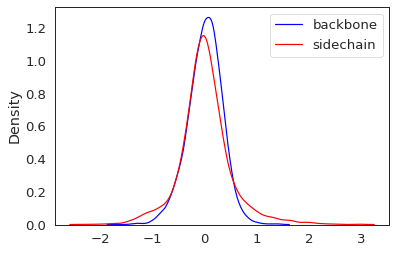

In [56]:
# negative z-score implied that intensity of the locscale map is less than that of predicted map
# positive z-score implied that intensity of the locscale map is greater than that of predicted map
# z-score = (locscale - predicted) / standard_error 

# compute z scores of backbone and sidechain atoms 

zscore_map, apix = load_map(z_score_map_path)

# compute z scores of backbone and sidechain atoms
zscore_backbone = zscore_map[atomic_point_map_backbone]
zscore_sidechain = zscore_map[atomic_point_map_side_chain]

sns.kdeplot(zscore_backbone, color='blue', label='backbone', fill=False)
sns.kdeplot(zscore_sidechain, color='red', label='sidechain', fill=False)
plt.legend()




In [57]:
# split based on atoms where intensity of locscale is lower than predicted intensity
atoms_where_locscale_is_lower_than_predicted_intensity = []
atoms_where_locscale_is_higher_than_predicted_intensity = []
sidechain_z_scores = []
backbone_z_scores = []
for cra in st[0].all():
    atom_pos = cra.atom.pos.tolist()
    atom_mrc_pos = convert_to_mrc_positition(atom_pos)
    z_atom = zscore_map[atom_mrc_pos[0], atom_mrc_pos[1], atom_mrc_pos[2]]
    
    if cra.atom.name in backbone_atoms:
        backbone_z_scores.append(z_atom)
        if z_atom < 0:
            atoms_where_locscale_is_lower_than_predicted_intensity.append(1)
        else:
            atoms_where_locscale_is_higher_than_predicted_intensity.append(1)
    else:
        sidechain_z_scores.append(z_atom)
        if z_atom < 0:
            atoms_where_locscale_is_lower_than_predicted_intensity.append(0)
        else:
            atoms_where_locscale_is_higher_than_predicted_intensity.append(0)



In [58]:
# print percentage of backbone atoms among atoms where locscale value is lower than predicted 

pc_backbone_when_locscale_lt_pred = sum(atoms_where_locscale_is_lower_than_predicted_intensity) / len(atoms_where_locscale_is_lower_than_predicted_intensity)
pc_backbone_when_locscale_gt_pred = sum(atoms_where_locscale_is_higher_than_predicted_intensity) / len(atoms_where_locscale_is_higher_than_predicted_intensity)

print("Percentage of backbone atoms among atoms where locscale value is lower than predicted: ", pc_backbone_when_locscale_lt_pred)
print("Percentage of backbone atoms among atoms where locscale value is greater than predicted: ", pc_backbone_when_locscale_gt_pred)





Percentage of backbone atoms among atoms where locscale value is lower than predicted:  0.45535595475715235
Percentage of backbone atoms among atoms where locscale value is greater than predicted:  0.4945539419087137


In [59]:
print("Median backbone zscore", np.median(backbone_z_scores))
print("Median sidechain zscore", np.median(sidechain_z_scores))

Median backbone zscore 0.02094852
Median sidechain zscore -0.0096262535


([<matplotlib.axis.XTick at 0x7efef56b0350>,
 [Text(1, 0, 'Backbone'), Text(2, 0, 'Sidechain')])

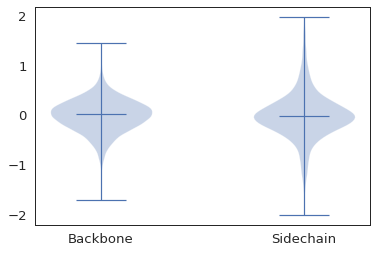

In [60]:
backbone_z_scores = np.array(backbone_z_scores)
sidechain_z_scores = np.array(sidechain_z_scores)
plt.violinplot([backbone_z_scores[abs(backbone_z_scores) < 2], sidechain_z_scores[abs(sidechain_z_scores) < 2]], showmeans=False, showmedians=True)
plt.xticks([1, 2], ['Backbone', 'Sidechain'])
